In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [19]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    ##################################################### repeatable!
    next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
                                   reuse=True)
    next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
                                reuse=True)
    gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
                         action_size=action_size, reuse=True)
    dones = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones)
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                     labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2, (1-dones)

In [20]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.dones__ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [22]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [23]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [25]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [26]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [27]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _, dones__ = sess.run([model.a_loss2, model.a_opt2, model.dones__], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            #print(dones__)
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:32.0000 R:32.0000 rate:0.0640 aloss:1.3986 dloss:1.6945 aloss2:1.9105 exploreP:0.9968
Episode:1 meanR:38.0000 R:44.0000 rate:0.0880 aloss:1.3982 dloss:1.6822 aloss2:1.9209 exploreP:0.9925
Episode:2 meanR:31.3333 R:18.0000 rate:0.0360 aloss:1.4014 dloss:1.6629 aloss2:1.9383 exploreP:0.9907
Episode:3 meanR:33.7500 R:41.0000 rate:0.0820 aloss:1.3984 dloss:1.6448 aloss2:1.9553 exploreP:0.9867
Episode:4 meanR:30.0000 R:15.0000 rate:0.0300 aloss:1.4006 dloss:1.6350 aloss2:1.9619 exploreP:0.9853
Episode:5 meanR:28.3333 R:20.0000 rate:0.0400 aloss:1.4010 dloss:1.6135 aloss2:1.9835 exploreP:0.9833
Episode:6 meanR:26.4286 R:15.0000 rate:0.0300 aloss:1.3981 dloss:1.6060 aloss2:1.9905 exploreP:0.9819
Episode:7 meanR:25.3750 R:18.0000 rate:0.0360 aloss:1.3961 dloss:1.6086 aloss2:1.9876 exploreP:0.9801
Episode:8 meanR:23.5556 R:9.0000 rate:0.0180 aloss:1.3935 dloss:1.6048 aloss2:1.9926 exploreP:0.9792
Episode:9 meanR:23.4000 R:22.0000 rate:0.0440 aloss:1.3946 dloss:1.5960 aloss2:1.99

Episode:80 meanR:21.2222 R:13.0000 rate:0.0260 aloss:1.4357 dloss:0.8548 aloss2:3.4493 exploreP:0.8436
Episode:81 meanR:21.2317 R:22.0000 rate:0.0440 aloss:1.4209 dloss:0.8524 aloss2:3.4947 exploreP:0.8418
Episode:82 meanR:21.2169 R:20.0000 rate:0.0400 aloss:1.4108 dloss:0.8374 aloss2:3.5230 exploreP:0.8401
Episode:83 meanR:21.1548 R:16.0000 rate:0.0320 aloss:1.4475 dloss:0.8287 aloss2:3.5428 exploreP:0.8388
Episode:84 meanR:21.2824 R:32.0000 rate:0.0640 aloss:1.4334 dloss:0.8186 aloss2:3.5446 exploreP:0.8362
Episode:85 meanR:21.1395 R:9.0000 rate:0.0180 aloss:1.4103 dloss:0.8411 aloss2:3.5738 exploreP:0.8354
Episode:86 meanR:21.2759 R:33.0000 rate:0.0660 aloss:1.4373 dloss:0.8187 aloss2:3.6314 exploreP:0.8327
Episode:87 meanR:21.3295 R:26.0000 rate:0.0520 aloss:1.4308 dloss:0.7921 aloss2:3.6798 exploreP:0.8306
Episode:88 meanR:21.2247 R:12.0000 rate:0.0240 aloss:1.4593 dloss:0.7987 aloss2:3.6974 exploreP:0.8296
Episode:89 meanR:21.2333 R:22.0000 rate:0.0440 aloss:1.4450 dloss:0.7933 a

Episode:159 meanR:22.7700 R:62.0000 rate:0.1240 aloss:1.3815 dloss:0.5058 aloss2:6.4698 exploreP:0.7046
Episode:160 meanR:23.6100 R:96.0000 rate:0.1920 aloss:1.3994 dloss:0.5075 aloss2:6.5397 exploreP:0.6979
Episode:161 meanR:23.8600 R:37.0000 rate:0.0740 aloss:1.3905 dloss:0.4924 aloss2:6.6565 exploreP:0.6954
Episode:162 meanR:24.6900 R:106.0000 rate:0.2120 aloss:1.3748 dloss:0.4905 aloss2:6.6942 exploreP:0.6882
Episode:163 meanR:24.6500 R:13.0000 rate:0.0260 aloss:1.3771 dloss:0.5104 aloss2:6.7116 exploreP:0.6873
Episode:164 meanR:25.4600 R:101.0000 rate:0.2020 aloss:1.3820 dloss:0.5030 aloss2:6.7547 exploreP:0.6805
Episode:165 meanR:25.6200 R:30.0000 rate:0.0600 aloss:1.3817 dloss:0.5014 aloss2:6.8397 exploreP:0.6785
Episode:166 meanR:25.6400 R:27.0000 rate:0.0540 aloss:1.3822 dloss:0.4872 aloss2:6.8483 exploreP:0.6767
Episode:167 meanR:26.6000 R:130.0000 rate:0.2600 aloss:1.3883 dloss:0.5029 aloss2:6.8879 exploreP:0.6681
Episode:168 meanR:26.5000 R:38.0000 rate:0.0760 aloss:1.3842 

Episode:238 meanR:116.2700 R:249.0000 rate:0.4980 aloss:1.7538 dloss:0.5968 aloss2:7.0889 exploreP:0.2425
Episode:239 meanR:117.8400 R:194.0000 rate:0.3880 aloss:1.7781 dloss:0.5743 aloss2:7.0998 exploreP:0.2380
Episode:240 meanR:120.7900 R:311.0000 rate:0.6220 aloss:1.8261 dloss:0.5687 aloss2:7.1911 exploreP:0.2311
Episode:241 meanR:122.3800 R:225.0000 rate:0.4500 aloss:1.8036 dloss:0.6391 aloss2:7.1939 exploreP:0.2261
Episode:242 meanR:124.0600 R:208.0000 rate:0.4160 aloss:1.7160 dloss:0.5959 aloss2:7.0909 exploreP:0.2217
Episode:243 meanR:126.3500 R:247.0000 rate:0.4940 aloss:1.7775 dloss:0.5772 aloss2:7.1761 exploreP:0.2165
Episode:244 meanR:127.9500 R:191.0000 rate:0.3820 aloss:1.7260 dloss:0.6067 aloss2:7.2509 exploreP:0.2126
Episode:245 meanR:129.9900 R:234.0000 rate:0.4680 aloss:1.7144 dloss:0.6337 aloss2:7.1557 exploreP:0.2079
Episode:246 meanR:132.8200 R:294.0000 rate:0.5880 aloss:1.7009 dloss:0.5989 aloss2:7.1137 exploreP:0.2022
Episode:247 meanR:135.8000 R:318.0000 rate:0.6

Episode:316 meanR:261.4300 R:247.0000 rate:0.4940 aloss:1.4058 dloss:0.8860 aloss2:5.5200 exploreP:0.0368
Episode:317 meanR:262.5900 R:500.0000 rate:1.0000 aloss:1.4122 dloss:0.8691 aloss2:5.5259 exploreP:0.0355
Episode:318 meanR:264.1800 R:311.0000 rate:0.6220 aloss:1.3963 dloss:0.8573 aloss2:5.5647 exploreP:0.0347
Episode:319 meanR:265.4200 R:258.0000 rate:0.5160 aloss:1.4163 dloss:0.8889 aloss2:5.5319 exploreP:0.0341
Episode:320 meanR:267.0900 R:210.0000 rate:0.4200 aloss:1.3929 dloss:0.9317 aloss2:5.4366 exploreP:0.0336
Episode:321 meanR:268.0800 R:259.0000 rate:0.5180 aloss:1.4030 dloss:0.8270 aloss2:5.4872 exploreP:0.0330
Episode:322 meanR:270.6200 R:500.0000 rate:1.0000 aloss:1.4005 dloss:0.8983 aloss2:5.4665 exploreP:0.0319
Episode:323 meanR:271.8700 R:307.0000 rate:0.6140 aloss:1.3917 dloss:0.9090 aloss2:5.3941 exploreP:0.0312
Episode:324 meanR:271.6100 R:197.0000 rate:0.3940 aloss:1.3996 dloss:0.8000 aloss2:5.4571 exploreP:0.0308
Episode:325 meanR:271.6900 R:224.0000 rate:0.4

Episode:394 meanR:298.1700 R:199.0000 rate:0.3980 aloss:1.3115 dloss:1.0691 aloss2:4.2735 exploreP:0.0126
Episode:395 meanR:298.0500 R:200.0000 rate:0.4000 aloss:1.2959 dloss:1.0944 aloss2:4.2314 exploreP:0.0125
Episode:396 meanR:299.7400 R:406.0000 rate:0.8120 aloss:1.3069 dloss:1.1084 aloss2:4.2332 exploreP:0.0124
Episode:397 meanR:300.4700 R:308.0000 rate:0.6160 aloss:1.3015 dloss:1.0956 aloss2:4.2085 exploreP:0.0124
Episode:398 meanR:301.1100 R:268.0000 rate:0.5360 aloss:1.3015 dloss:1.0898 aloss2:4.2515 exploreP:0.0123


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

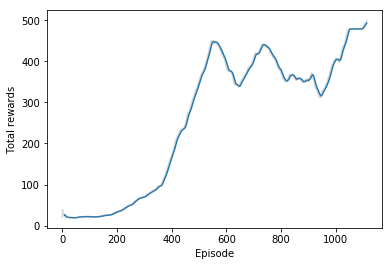

In [57]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

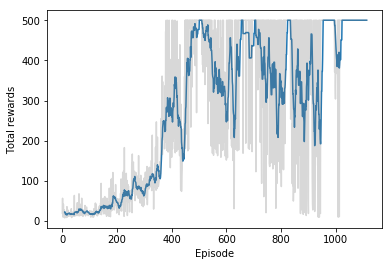

In [58]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.